In [3]:
import sys
import pandas as pd
import numpy as np
import itertools
import atomium
sys.path.append('../../graph_toolbox/')
from feature import calc_named
from parse.read_library_free import read_pdb_basic, read_pdb, find_cba_atoms, read_pdb_full
from feature.calc import calc_struct_properties, calc_named, FEATNAME
from parse.atomium_utils import atomium_select, atomium_chain_pdb_list
from feature.calc_numpy import calc_struct_properties as calc_struct_properties_np

### Truncate sequences

In [2]:
def ordered_atomium(path):
    struct = atomium.open(path).model
    pdb_list = atomium_chain_pdb_list(struct)
    return atomium_select(struct, pdb_list=pdb_list, chain='A')

In [3]:
xyz = np.random.rand(200, 3)
rdist = xyz[:,np.newaxis] - xyz[np.newaxis,:]

In [4]:
p = 'data/6iii.pdb'
resname, resatom, res_atnum, xyz, ca, cb = read_pdb_full(p)

In [5]:
import torch as th
u, v, feats = calc_struct_properties(*read_pdb_full(p))


In [6]:
feats.shape

torch.Size([4106, 19])

In [7]:
df

,disulfide,hydrophobic,cation_pi,arg_arg,salt_bridge,hbond,vdw,1/caca,ca_vs_cb,self,is_seq,is_seq_not,is_struct,res1,res2
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0,0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.260983,0.0,0.0,1.0,0.0,0.0,0,1
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.151841,0.0,0.0,0.0,0.0,1.0,0,2
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.102557,0.0,0.0,0.0,0.0,1.0,0,3
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.076469,0.0,0.0,0.0,0.0,1.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.087809,1.0,0.0,0.0,0.0,1.0,459,455
211596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.119764,1.0,0.0,0.0,0.0,1.0,459,456
211597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.177493,1.0,0.0,0.0,0.0,1.0,459,457
211598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.260205,0.0,0.0,1.0,0.0,0.0,459,458


In [6]:
df = calc_named(p, None, None)

In [8]:
r = th.BoolTensor([True, False])

In [12]:
df.describe()

,disulfide,hydrophobic,cation_pi,arg_arg,salt_bridge,hbond,vdw,1/caca,ca_vs_cb,self,is_seq,is_seq_not,is_struct,res1,res2
count,211600.0,211600.000000,211600.000000,211600.0,211600.0,211600.0,211600.000000,211600.000000,211600.000000,211600.000000,211600.000000,211600.000000,211600.000000,211600.000000,211600.000000
mean,0.0,0.002174,0.006522,0.0,0.0,0.0,0.008696,0.042440,0.367812,0.002174,0.004338,0.976229,0.993488,229.500000,229.500000
std,0.0,0.046524,0.080263,0.0,0.0,0.0,0.093092,0.029300,0.482389,0.046542,0.065680,0.152224,0.080402,132.790562,132.790562
min,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.025739,0.000000,0.000000,0.000000,1.000000,1.000000,114.750000,114.750000
50%,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.034023,0.000000,0.000000,0.000000,1.000000,1.000000,229.500000,229.500000
75%,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.048350,1.000000,0.000000,0.000000,1.000000,1.000000,344.250000,344.250000
max,0.0,1.000000,1.000000,0.0,0.0,0.0,1.000000,0.267728,1.000000,1.000000,1.000000,1.000000,1.000000,459.000000,459.000000


In [10]:
dfn = pd.DataFrame(feats.numpy(), columns=FEATNAME)

ValueError: Shape of passed values is (4106, 19), indices imply (4106, 13)

In [ ]:
dfn[['cx',  'cy', 'cz', 'ljx', 'ljy', 'ljz']].describe().round(2)

,cx,cy,cz,ljx,ljy,ljz
count,4106.00,4106.00,4106.00,4106.00,4106.00,4106.00
mean,0.11,0.30,-0.72,13.32,66.49,210.07
std,0.51,0.44,0.73,426.67,2129.33,6728.55
min,-3.64,-2.57,-6.10,-2.07,-0.25,-1.64
25%,-0.08,0.06,-0.92,0.00,0.00,0.00
50%,0.06,0.23,-0.51,0.00,0.00,0.00
75%,0.29,0.47,-0.28,0.00,0.00,0.00
max,2.32,2.48,-0.00,13674.50,68248.91,215643.22


In [ ]:
cb_ca_diff = cbcb - caca
cbca = th.cdist(ca, cb)

NameError: name 'cbcb' is not defined

In [ ]:
caca_xyz = (ca.view(-1, 3, 1) - ca.view(1, 3, -1)).swapdims(1, 2)

In [ ]:
caca_xyz = ca[:, None] - ca[None, :]

In [ ]:
caca_xyz.shape

torch.Size([460, 460, 3])

In [ ]:
cos_angle = cb_ca_diff/(cbca*2)

<AxesSubplot:>

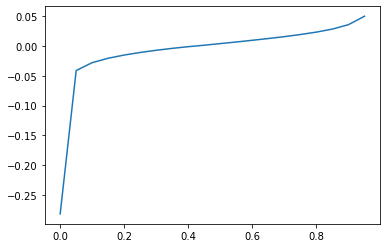

In [ ]:
pd.Series(cos_angle.ravel().numpy()).quantile(np.arange(0, 1, 0.05)).plot()

In [ ]:
df =  calc_named(p, None)

In [ ]:
%prun calc_struct_properties(*read_pdb_full(p))


         46376 function calls in 0.819 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      461    0.320    0.001    0.320    0.001 {method 'split_with_sizes' of 'torch._C._TensorBase' objects}
        5    0.137    0.027    0.137    0.027 {built-in method cat}
        1    0.118    0.118    0.718    0.718 calc.py:242(calc_struct_properties)
        1    0.066    0.066    0.819    0.819 <string>:1(<module>)
       11    0.031    0.003    0.032    0.003 calc.py:34(is_atom_in_group)
        2    0.029    0.015    0.029    0.015 {built-in method pow}
        1    0.024    0.024    0.024    0.024 {method 'float' of 'torch._C._TensorBase' objects}
     4106    0.019    0.000    0.019    0.000 {method 'sum' of 'torch._C._TensorBase' objects}
     3701    0.016    0.000    0.016    0.000 {method 'split' of 're.Pattern' objects}
        3    0.013    0.004    0.013    0.004 {built-in method cdist}
        1    0.006    0.006    0.

In [ ]:
%prun calc_struct_properties_np(*read_pdb_full(p))

         1758064 function calls (1545080 primitive calls) in 2.293 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
213458/474    0.718    0.000    1.203    0.003 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1    0.570    0.570    2.241    2.241 calc_numpy.py:248(calc_struct_properties)
        3    0.231    0.077    0.447    0.149 calc_numpy.py:35(cdist)
     4111    0.224    0.000    0.224    0.000 {method 'reduce' of 'numpy.ufunc' objects}
      461    0.147    0.000    0.554    0.001 shape_base.py:739(array_split)
   212984    0.087    0.000    0.391    0.000 <__array_function__ internals>:2(swapaxes)
   212984    0.071    0.000    0.071    0.000 {method 'swapaxes' of 'numpy.ndarray' objects}
   212984    0.066    0.000    0.157    0.000 fromnumeric.py:51(_wrapfunc)
   212984    0.056    0.000    0.213    0.000 fromnumeric.py:550(swapaxes)
   212984    0.021    0.000    0.021    0.000 f

In [ ]:
cb_xyz_list

NameError: name 'cb_xyz_list' is not defined

In [ ]:
cb_xyz_list

[array([  3.76 ,  58.268, 142.474], dtype=float32),
 array([  1.788,  58.029, 147.516], dtype=float32),
 array([ -3.742,  58.013, 145.992], dtype=float32),
 array([ -2.713,  60.778, 151.21 ], dtype=float32),
 array([ -8.304,  60.053, 151.067], dtype=float32),
 array([ -8.404,  64.651, 154.055], dtype=float32),
 array([-11.25 ,  59.263, 154.785], dtype=float32),
 array([ -9.939,  60.272, 159.747], dtype=float32),
 array([ -9.203,  65.247, 158.208], dtype=float32),
 array([-13.412,  65.239, 155.174], dtype=float32),
 array([-15.99 ,  61.548, 157.364], dtype=float32),
 array([-14.507,  61.579, 162.189], dtype=float32),
 array([-15.569,  67.595, 162.28 ], dtype=float32),
 array([-15.441,  67.524, 167.138], dtype=float32),
 array([-12.774,  62.403, 166.327], dtype=float32),
 array([ -8.441,  64.485, 165.179], dtype=float32),
 array([ -5.722,  68.313, 168.062], dtype=float32),
 array([ -4.983,  69.931, 162.585], dtype=float32),
 array([ -0.498,  68.957, 165.899], dtype=float32),
 array([  3.